# Player B Report

## Section 1: Performing Correlation on all Biomechanical Markers Irrelevant of Pitch Type Using *.corr()*

### Findings Summary (Average)
1. Weak correlation between *pitching_elbow_flexion_extension_at_footstrike* and *fatigue_score* with a **threshold = 0.25**

In [1]:
# import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import f_regression
from sklearn.ensemble import RandomForestRegressor

In [2]:
# import csv files as dataframes 
fatigue = pd.read_csv('fatigue_index.csv', index_col=False)
pitching = pd.read_csv('pitching_mechanics.csv', index_col=False)

In [3]:
# drop rows with values = NaN
fatigue.dropna(inplace=True)
pitching.dropna(inplace=True)

In [4]:
fatigue.head()

,player_id,report_date,game_date,score,last_outing_pitches,pitch_last_4_days,consec,cumulative_inning_pitched
0,pitcher A,2022-04-09,2022-04-01 00:00:00.000000 UTC,0.000000,33.0,0.0,0,0.0
1,pitcher A,2022-04-10,2022-04-01 00:00:00.000000 UTC,0.000000,33.0,0.0,0,0.0
2,pitcher A,2022-04-11,2022-04-10 00:00:00.000000 UTC,12.157287,16.0,16.0,1,2.0
3,pitcher A,2022-04-12,2022-04-10 00:00:00.000000 UTC,5.269455,16.0,16.0,1,2.0
4,pitcher A,2022-04-13,2022-04-12 00:00:00.000000 UTC,17.126998,21.0,37.0,2,3.0


In [5]:
# convert to datetime and format as 'YYYY-MM-DD'
# necessary to join data later
fatigue['game_date'] = pd.to_datetime(fatigue['game_date'].str.replace(" UTC", "", regex=False)).dt.strftime('%Y-%m-%d')

In [6]:
# filter to create two new dataframes for specifically for player B
player_b_fatigue = fatigue[fatigue['player_id'] == 'pitcher B']
player_b_pitching = pitching[pitching['player_id'] == 'pitcher B']

In [7]:
player_b_fatigue.head()

,player_id,report_date,game_date,score,last_outing_pitches,pitch_last_4_days,consec,cumulative_inning_pitched
172,pitcher B,2022-04-09,2022-04-08,14.707498,17.0,17.0,1,0.666667
173,pitcher B,2022-04-10,2022-04-09,13.553575,9.0,26.0,2,1.666667
174,pitcher B,2022-04-11,2022-04-09,7.647263,9.0,26.0,2,1.666667
175,pitcher B,2022-04-14,2022-04-09,0.000000,9.0,0.0,0,1.666667
176,pitcher B,2022-04-16,2022-04-09,0.000000,9.0,0.0,0,1.666667


In [8]:
player_b_pitching.head()

,player_id,game_date,pitcher_throws,pitch_release_velocity,pitch_spin_rate,inning,pitch_type,hip_shoulder_separation_at_footstrike,pitching_shoulder_abduction_at_footstrike,pitching_shoulder_horizontal_abduction_at_footstrike,...,hip_internal_rotation_external_rotation_lead_leg_at_release,knee_flexion_extension_drive_leg_at_release,knee_flexion_extension_lead_leg_at_release,trunk_forward_bend_at_release,trunk_side_bend_at_release,trunk_rotation_at_release,pelvis_rotation_at_release,arm_slot_degree_at_release,max_pitching_shoulder_external_rotation,max_hip_shoulder_separation
800,pitcher B,2022-04-08,right,96.547132,2394.479901,10,four_seam,-44.406000,91.496736,42.687981,...,78.444678,35.443500,6.058214,25.186437,36.050816,119.854613,76.410368,58.0,-180.805090,-50.667935
801,pitcher B,2022-04-08,right,95.599831,2358.245778,10,four_seam,-46.197702,90.070929,41.285383,...,25.181576,43.274137,20.256091,28.270518,37.801666,120.108475,77.162845,57.0,-178.126689,-52.503119
802,pitcher B,2022-04-08,right,84.624907,2555.922635,10,slider,-46.228469,85.977034,35.956797,...,-6.588953,38.631417,46.919033,30.053590,40.215634,116.319403,67.612843,54.0,-180.429796,-53.560788
803,pitcher B,2022-04-08,right,84.747500,2547.728844,10,slider,-48.749298,88.395645,37.565388,...,-2.931601,43.525318,39.295010,30.050295,40.858948,116.640390,72.238523,50.0,-179.065094,-54.953275
804,pitcher B,2022-04-08,right,85.512595,2481.512994,10,slider,-46.346477,88.421046,41.750671,...,-1.322585,40.994748,21.443048,28.497826,44.322317,117.186561,68.904523,51.0,-175.870296,-51.307213


In [9]:
# grab the date of the games player B pitched in
pitching_game_dates = player_b_pitching['game_date'].unique().tolist()

In [10]:
# return correlated markers based on given threshold
def get_correlated_markers(df, threshold):
    # create an empty dictionary to store the correlated markers
    correlated_markers = {}
    # iterate through the columns of the dataframe
    for marker in df.columns:
        # if the correlation value is greater than the threshold and the marker is not the fatigue_score
        # add the marker and correlation value to the dictionary
        if abs(df[marker].corr(df['fatigue_score'])) > threshold and marker != 'fatigue_score':
            correlated_markers[marker] = df[marker].corr(df['fatigue_score'])
    return correlated_markers

In [11]:
# get the average values for each biomechanical marker for each game player B pitched in
# append the fatigue score for each game to the dataframe
# I will use this dataframe to run the correlation analysis
def get_average(df1, df2, dates):
    # create an empty list to store the dataframes
    mean_df = []
    # iterate through the list of dates
    for date in dates:
        # get the first row of the fatigue dataframe for the date
        # I only care about the first row because the fatigue score is highest the day after the game
        temp_fatigue = df1[df1['game_date'] == date].iloc[0:1]
        fatigue_score = temp_fatigue['score'].values[0]

        # get the rows of the pitching dataframe for the date
        temp_pitching = df2[df2['game_date'] == date].copy()
        # drop columns that mess with the mean() function
        temp_pitching.drop(['player_id', 'game_date', 'pitcher_throws', 'inning', 'pitch_type', 'pitch_release_velocity', 'pitch_spin_rate'], axis=1, inplace=True)
        # create a df with the mean values for each biomechanical marker
        temp_pitching_mean = temp_pitching.mean().to_frame().T
        # add the fatigue score to the dataframe
        temp_pitching_mean['fatigue_score'] = fatigue_score
        #temp_pitching_mean.insert(0, 'game_date', date)
        
        # append the dataframe to the list
        mean_df.append(temp_pitching_mean)

    # concatenate the list of dataframes into one dataframe
    return pd.concat(mean_df)

In [12]:
average_df = get_average(player_b_fatigue, player_b_pitching, pitching_game_dates)

In [13]:
average_df.head()

,hip_shoulder_separation_at_footstrike,pitching_shoulder_abduction_at_footstrike,pitching_shoulder_horizontal_abduction_at_footstrike,pitching_shoulder_internal_rotation_external_rotation_at_footstrike,pitching_elbow_flexion_extension_at_footstrike,hip_flexion_extension_drive_leg_at_footstrike,hip_abduction_adduction_drive_leg_at_footstrike,hip_internal_rotation_external_rotation_drive_leg_at_footstrike,hip_flexion_extension_lead_leg_at_footstrike,hip_abduction_adduction_lead_leg_at_footstrike,...,knee_flexion_extension_drive_leg_at_release,knee_flexion_extension_lead_leg_at_release,trunk_forward_bend_at_release,trunk_side_bend_at_release,trunk_rotation_at_release,pelvis_rotation_at_release,arm_slot_degree_at_release,max_pitching_shoulder_external_rotation,max_hip_shoulder_separation,fatigue_score
0,-46.469439,87.843780,38.830329,-13.388228,111.363991,-8.700201,36.950582,41.695129,46.041992,30.188318,...,40.094577,27.862831,28.177167,39.614909,117.546735,73.328682,53.875000,-178.534793,-53.052120,14.707498
0,-46.677429,83.388601,33.440534,-14.898139,109.678089,-12.182034,34.879577,39.458858,44.620862,34.356472,...,44.012194,34.191437,21.105485,43.033132,116.379506,67.418784,50.625000,-176.941758,-56.174770,13.553575
0,-41.392954,86.643089,34.722836,-20.224475,111.795075,-4.863143,36.133911,50.187208,40.632147,34.280418,...,43.162111,33.517824,26.168809,38.710063,116.578845,76.032447,53.500000,-180.033714,-45.752764,11.984878
0,-37.487998,84.087067,41.054172,-20.479675,118.049899,-7.063998,33.666946,47.686033,41.667531,36.105028,...,44.063171,31.791690,25.486153,41.216065,113.895761,72.697420,53.800000,-178.017089,-41.534953,21.666976
0,-41.226661,88.259203,43.746763,-21.964758,114.327472,-13.811491,33.788531,37.417033,43.053600,30.791523,...,42.598741,33.686222,26.288770,40.907327,116.188724,71.791309,52.363636,-179.082302,-44.451923,19.172339


In [14]:
# get correlated markers with a threshold of 0.5
get_correlated_markers(average_df, 0.5)

{}

In [15]:
# get correlated markers with a threshold of 0.4
get_correlated_markers(average_df, 0.4)

{}

In [16]:
get_correlated_markers(average_df, 0.3)

{}

In [17]:
get_correlated_markers(average_df, 0.2)

{'pitching_elbow_flexion_extension_at_footstrike': 0.2490681627489902}

## Section 2: Performing Correlation on all Biomechanical Markers Irrelevant of Pitch Type Using *.corrwith()* and Linear Regression

### Finding Summary (Average):
No significant biomechanical markers

In [18]:
# drop the fatigue_score column to use the biomechanical markers as features
features = average_df.drop('fatigue_score', axis=1)
# set the target variable as the fatigue_score
target = average_df['fatigue_score']

In [19]:
# Compute correlations
correlations = features.corrwith(target).sort_values(ascending=False)
print("Correlation of biomechanical markers with fatigue score:\n", correlations)

Correlation of biomechanical markers with fatigue score:
 pitching_elbow_flexion_extension_at_footstrike                         0.249068
pitching_shoulder_horizontal_abduction_at_footstrike                   0.184251
stride_horizontal_angle_at_footstrike                                  0.177109
hip_abduction_adduction_drive_leg_at_release                           0.159658
hip_abduction_adduction_drive_leg_at_footstrike                        0.110939
trunk_rotation_at_footstrike                                           0.090251
pelvis_rotation_at_footstrike                                          0.089012
trunk_forward_bend_at_release                                          0.072309
pitching_elbow_flexion_extension_at_release                            0.049767
stride_length_at_footstrike                                            0.047970
knee_flexion_extension_lead_leg_at_footstrike                          0.030640
hip_flexion_extension_lead_leg_at_release                     

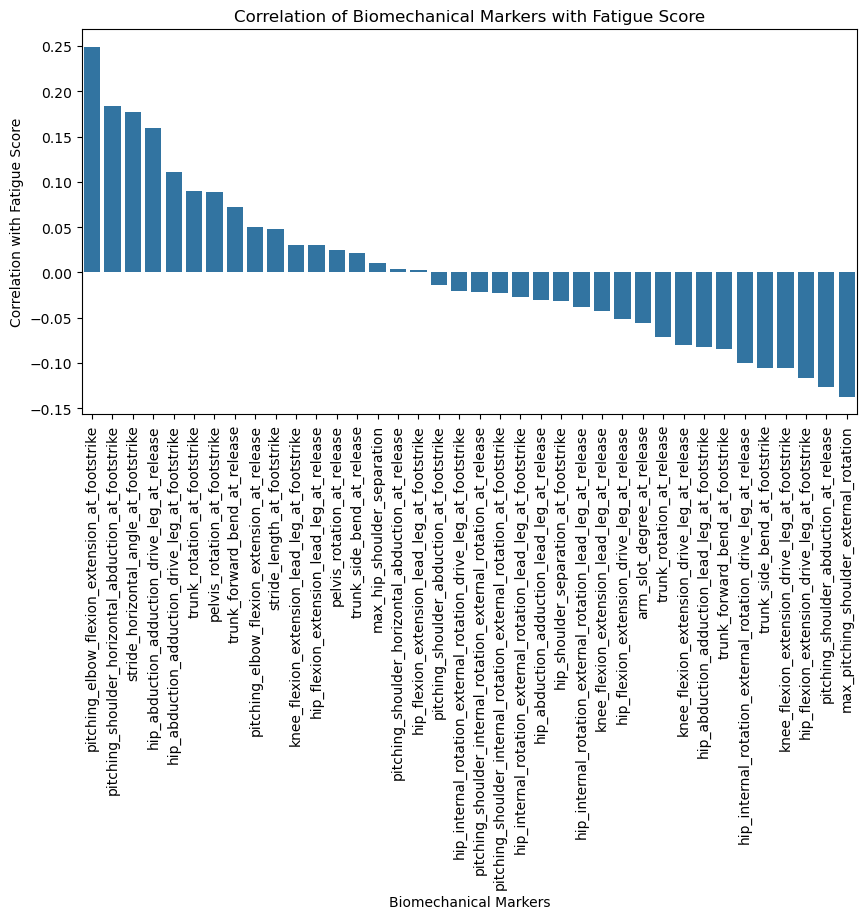


Feature Importance:
                                               Feature  Coefficient   F-Value  \
4      pitching_elbow_flexion_extension_at_footstrike     0.061548  3.306890   
2   pitching_shoulder_horizontal_abduction_at_foot...    -0.486485  1.757073   
17              stride_horizontal_angle_at_footstrike     5.519346  1.619175   
24       hip_abduction_adduction_drive_leg_at_release    -2.302237  1.307872   
36            max_pitching_shoulder_external_rotation    -0.676796  0.962113   
19             pitching_shoulder_abduction_at_release    -1.637649  0.816977   
5       hip_flexion_extension_drive_leg_at_footstrike    -1.541351  0.683185   
6     hip_abduction_adduction_drive_leg_at_footstrike     1.591450  0.623036   
11     knee_flexion_extension_drive_leg_at_footstrike     1.197346  0.566071   
14                      trunk_side_bend_at_footstrike    -2.835333  0.563121   
25  hip_internal_rotation_external_rotation_drive_...    -1.326573  0.508810   
15                

In [20]:
# Plot correlations
plt.figure(figsize=(10, 5))
sns.barplot(x=correlations.index, y=correlations.values)
plt.xticks(rotation=90)
plt.xlabel("Biomechanical Markers")
plt.ylabel("Correlation with Fatigue Score")
plt.title("Correlation of Biomechanical Markers with Fatigue Score")
plt.show()

# Feature selection using linear regression
reg = LinearRegression()
reg.fit(features, target)

# Compute F-statistics and p-values
f_values, p_values = f_regression(features, target)

# Create a DataFrame to summarize results
feature_importance = pd.DataFrame({
    'Feature': features.columns,
    'Coefficient': reg.coef_,
    'F-Value': f_values,
    'P-Value': p_values
}).sort_values(by='P-Value')

print("\nFeature Importance:\n", feature_importance)

# Identify significant markers (p < 0.05)
significant_markers = feature_importance[feature_importance['P-Value'] < 0.05]
print("\nSignificant Biomechanical Markers:", significant_markers['Feature'].tolist())


## Section 3: Using a Random Forest

### Summary:
Finally, I tried using a machine learning model to see if I could catch any intricate patterns not noticed by the linear regression model. After running the model, *hip_abduction_adduction_drive_leg_at_release* seems to be the best preditctor, but it is weak at best.

In [21]:
# drop the fatigue_score column to use the biomechanical markers as features
X = average_df.drop('fatigue_score', axis=1)
# set the target variable as the fatigue_score
y = average_df['fatigue_score']

# create a random forest regressor model
model = RandomForestRegressor()
# fit the model to the data
model.fit(X, y)

# get the feature importances from the model
importance = model.feature_importances_
feature_importance = pd.Series(importance, index=X.columns)
feature_importance = feature_importance.sort_values(ascending=False)

# print the feature importances
print(feature_importance)

hip_abduction_adduction_drive_leg_at_release                           0.075208
trunk_rotation_at_release                                              0.061913
pitching_shoulder_horizontal_abduction_at_footstrike                   0.059407
stride_horizontal_angle_at_footstrike                                  0.049620
knee_flexion_extension_lead_leg_at_release                             0.045159
arm_slot_degree_at_release                                             0.045009
hip_internal_rotation_external_rotation_drive_leg_at_release           0.041649
hip_flexion_extension_drive_leg_at_release                             0.039163
pitching_elbow_flexion_extension_at_release                            0.033435
pitching_elbow_flexion_extension_at_footstrike                         0.033293
pitching_shoulder_horizontal_abduction_at_release                      0.032855
hip_flexion_extension_lead_leg_at_release                              0.027043
trunk_rotation_at_footstrike            